In [ ]:
import pandas as pd
import numpy as np

# Machine learning libraries
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

# Imbalanced data handling
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Read CSV file
df = pd.read_csv('~/Desktop/chm_jail_data.csv')

In [ ]:
# Remove rows where 'offense_level' is 'Can't Classify' or 'NOT CLASSIFIED'
df = df[~df['offense_level'].isin(["Can't Classify", "NOT CLASSIFIED"])].reset_index(drop=True)

print("\nUnique offense levels after filtering:")
print(df['offense_level'].unique())



Unique offense levels after filtering:
['Misdemeanor' 'Other (OV, Civil)' 'Felony' nan]


We calculate recidivism by identifying inmates with the same jacket number that were booked on separate dates. This indicates recidivism.

In [ ]:
df['booking_date'] = pd.to_datetime(df['booking_date'])
# Group by 'jacket_number' and count unique booking dates
booking_counts = df.groupby('jacket_number')['booking_date'].nunique().reset_index()
booking_counts.columns = ['jacket_number', 'booking_count']

# Identify jacket_numbers with more than one unique booking date
repeat_jacket_numbers = booking_counts[booking_counts['booking_count'] > 1]['jacket_number']

# Filter the main DataFrame to include only these jacket_numbers
df_repeat = df[df['jacket_number'].isin(repeat_jacket_numbers)].reset_index(drop=True)

print(f"\nNumber of jacket_numbers with multiple bookings: {len(repeat_jacket_numbers)}")



Number of jacket_numbers with multiple bookings: 6830


In [22]:
# Sort by 'jacket_number' and 'booking_date' to ensure chronological order
df_repeat = df_repeat.sort_values(by=['jacket_number', 'booking_date'])

# Keep the first booking record for each 'jacket_number'
df_first_booking = df_repeat.groupby('jacket_number').first().reset_index()

print(f"\nNumber of records after selecting first bookings: {df_first_booking.shape[0]}")



Number of records after selecting first bookings: 6830


In [ ]:
# Create a 'recidivism' label: 1 if booking_count > 1, else 0
booking_counts['recidivism'] = 1  # Since all jacket_numbers here have booking_count > 1

# Merge the 'recidivism' label back into the first booking DataFrame
df_first_booking = df_first_booking.merge(
    booking_counts[['jacket_number', 'recidivism']], on='jacket_number', how='left'
)

from collections import Counter
print("\nRecidivism class distribution:")
print(Counter(df_first_booking['recidivism']))



Recidivism class distribution:
Counter({1: 6830})


In [ ]:
# Identify jacket_numbers with only one booking
non_repeat_jacket_numbers = booking_counts[booking_counts['booking_count'] == 1]['jacket_number']

df_non_repeat = df[df['jacket_number'].isin(non_repeat_jacket_numbers)].reset_index(drop=True)

# Create 'recidivism' label as 0
df_non_repeat['recidivism'] = 0

# Combine recidivists and non-recidivists
df_combined = pd.concat([df_first_booking, df_non_repeat], ignore_index=True)

print("\nCombined recidivism class distribution:")
print(Counter(df_combined['recidivism']))



Combined recidivism class distribution:
Counter({0: 20780, 1: 6830})


In [ ]:
# Define features and target
features = [
    'age_at_arrest', 'marital_status', 'employment_status', 'citizenship',
    'education_status', 'arrest_agency', 'booking_reason', 'crime', 'statute',
    'sex', 'race'
]
target = 'recidivism'

X = df_combined[features]
y = df_combined[target]


In [ ]:
# Missing value handling
print("\nMissing values before handling:")
print(X.isnull().sum())

# Separate numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Impute numerical columns
num_imputer = SimpleImputer(strategy='mean')
X[numerical_cols] = num_imputer.fit_transform(X[numerical_cols])

# Impute categorical columns
cat_imputer = SimpleImputer(strategy='most_frequent')
X[categorical_cols] = cat_imputer.fit_transform(X[categorical_cols])

# Verify missing values are handled
print("\nMissing values after handling:")
print(X.isnull().sum())



Missing values before handling:
age_at_arrest           8
marital_status        263
employment_status     270
citizenship           233
education_status     2747
arrest_agency         221
booking_reason        114
crime                1239
statute              1239
sex                     8
race                  149
dtype: int64

Missing values after handling:
age_at_arrest          0
marital_status         5
employment_status      4
citizenship            6
education_status     208
arrest_agency          4
booking_reason         0
crime                  2
statute                2
sex                    3
race                   6
dtype: int64


In [ ]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform the categorical features
X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_cols]))
X_encoded.columns = encoder.get_feature_names_out(categorical_cols)
X_encoded.reset_index(drop=True, inplace=True)

# Numerical features
X_numerical = X[numerical_cols].reset_index(drop=True)

# Combine numerical and encoded categorical features
X_processed = pd.concat([X_numerical, X_encoded], axis=1)


In [ ]:
scaler = StandardScaler()

# Fit and transform the processed features
X_scaled = scaler.fit_transform(X_processed)


In [ ]:
y = y.values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
print("\nInitial class distribution in training set:")
print(Counter(y_train))

# Apply SMOTE to the training data to satisfy imbalances
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Verify new class distribution
print("\nClass distribution after SMOTE:")
print(Counter(y_train_resampled))



Initial class distribution in training set:
Counter({0: 16624, 1: 5464})

Class distribution after SMOTE:
Counter({0: 16624, 1: 16624})


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Build the model
model_nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_nn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)


In [33]:
# Initialize the Random Forest model
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model_rf.fit(X_train_resampled, y_train_resampled)


RandomForestClassifier(random_state=42)

In [34]:
# Predict on the test set
y_pred = model_rf.predict(X_test)
y_pred_proba = model_rf.predict_proba(X_test)[:, 1]

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")



Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      4156
           1       0.50      0.36      0.42      1366

    accuracy                           0.75      5522
   macro avg       0.65      0.62      0.63      5522
weighted avg       0.73      0.75      0.74      5522


Confusion Matrix:
[[3665  491]
 [ 874  492]]

ROC-AUC Score: 0.7322


In [36]:
# Calculate accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy * 100:.2f}%")



Model Accuracy: 75.28%


Incorporating an adversarial component into a Random Forest model is not straightforward due to its ensemble nature and lack of internal representations that can be manipulated like in neural networks. Random Forests are less flexible in architecture compared to neural networks. We include the choice of Random Forest as a selected model to later assess if the adversarial model outperforms other types of machine learning algorithms, not simply limited to neural networks.

In [65]:
# Necessary libraries for the NN implementation
import pandas as pd
import numpy as np


from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


from imblearn.over_sampling import SMOTE


import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Define the input shape
input_dim = X_train_resampled.shape[1]

# Build the model
model_nn = Sequential()
model_nn.add(Dense(128, activation='relu', input_dim=input_dim))
model_nn.add(Dropout(0.5))
model_nn.add(Dense(64, activation='relu'))
model_nn.add(Dropout(0.5))
model_nn.add(Dense(32, activation='relu'))
model_nn.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [40]:
# Train the model
history = model_nn.fit(
    X_train_resampled,
    y_train_resampled,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50
1039/1039 [==============================] - 1s 1ms/step - loss: 0.6372 - accuracy: 0.6503 - val_loss: 0.5912 - val_accuracy: 0.6557
Epoch 2/50
1039/1039 [==============================] - 1s 827us/step - loss: 0.5734 - accuracy: 0.6972 - val_loss: 0.5908 - val_accuracy: 0.6514
Epoch 3/50
1039/1039 [==============================] - 1s 796us/step - loss: 0.5576 - accuracy: 0.7086 - val_loss: 0.5867 - val_accuracy: 0.6463
Epoch 4/50
1039/1039 [==============================] - 1s 756us/step - loss: 0.5492 - accuracy: 0.7138 - val_loss: 0.6091 - val_accuracy: 0.6489
Epoch 5/50
1039/1039 [==============================] - 1s 813us/step - loss: 0.5414 - accuracy: 0.7220 - val_loss: 0.5862 - val_accuracy: 0.6633
Epoch 6/50
1039/1039 [==============================] - 1s 815us/step - loss: 0.5323 - accuracy: 0.7267 - val_loss: 0.5973 - val_accuracy: 0.6693
Epoch 7/50
1039/1039 [==============================] - 1s 894us/step - loss: 0.5293 - accuracy: 0.7284 - val_loss: 0.6000 - v

Matplotlib is building the font cache; this may take a moment.


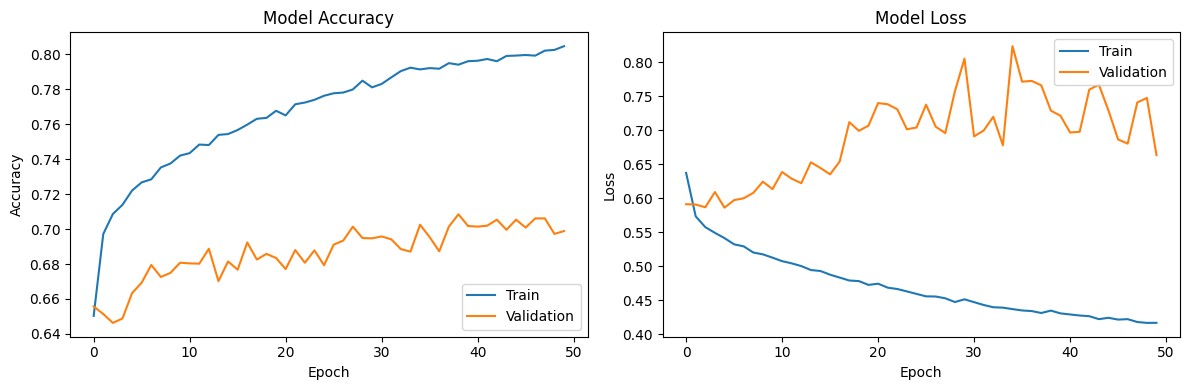

In [41]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()


In [ ]:
# Predict probabilities
y_pred_proba = model_nn.predict(X_test)

# Predict classes
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")


173/173 [==============================] - 0s 409us/step

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.73      0.79      4156
           1       0.42      0.59      0.49      1366

    accuracy                           0.70      5522
   macro avg       0.63      0.66      0.64      5522
weighted avg       0.74      0.70      0.71      5522


Confusion Matrix:
[[3052 1104]
 [ 559  807]]

ROC-AUC Score: 0.7244


In [43]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy * 100:.2f}%")



Model Accuracy: 69.88%


In [71]:
# 1. Obtain predictions from the main model
y_pred_proba_main = model_nn.predict(X_test)
y_pred_main = (y_pred_proba_main > 0.5).astype(int).flatten()

# 2. Combine predictions with sensitive attributes
results_df_main = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred_main
})

sensitive_test_df = pd.DataFrame(sensitive_test, columns=sensitive_encoded.columns)
results_df_main = pd.concat([results_df_main.reset_index(drop=True), sensitive_test_df.reset_index(drop=True)], axis=1)

# 3. Use the existing demographic_parity_difference function
def demographic_parity_difference(df, sensitive_prefix):
    sensitive_cols = [col for col in df.columns if col.startswith(sensitive_prefix)]
    dpd_values = {}
    for col in sensitive_cols:
        group = df[df[col] == 1]
        if len(group) > 0:
            rate = group['y_pred'].mean()
            dpd_values[col] = rate
        else:
            dpd_values[col] = np.nan  # Handle groups with no instances
    max_rate = max([v for v in dpd_values.values() if not np.isnan(v)])
    min_rate = min([v for v in dpd_values.values() if not np.isnan(v)])
    dpd = max_rate - min_rate
    return dpd, dpd_values

# 4. Calculate DPD for 'race'
dpd_race_main, dpd_race_values_main = demographic_parity_difference(results_df_main, 'race_')
print(f"\nDemographic Parity Difference (Race) for Main Model: {dpd_race_main:.4f}")
print("Rates by Race for Main Model:")
for race, rate in dpd_race_values_main.items():
    print(f"  {race}: {rate:.4f}")

# 5. Calculate DPD for 'sex'
dpd_sex_main, dpd_sex_values_main = demographic_parity_difference(results_df_main, 'sex_')
print(f"\nDemographic Parity Difference (Sex) for Main Model: {dpd_sex_main:.4f}")
print("Rates by Sex for Main Model:")
for sex, rate in dpd_sex_values_main.items():
    print(f"  {sex}: {rate:.4f}")


173/173 [==============================] - 0s 438us/step

Demographic Parity Difference (Race) for Main Model: 0.6667
Rates by Race for Main Model:
  race_Asian/Pacific Islander: 0.0360
  race_Black: 0.5751
  race_Hispanic: 0.1046
  race_Native American: 0.2500
  race_Unknown: 0.0000
  race_White: 0.2151
  race_White (Hispanic): 0.6667

Demographic Parity Difference (Sex) for Main Model: 0.0953
Rates by Sex for Main Model:
  sex_Female: 0.2770
  sex_Male: 0.3723


In [ ]:
# Necessary libraries to build the adversarial training model
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout


import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Define features and target
features = [
    'age_at_arrest', 'marital_status', 'employment_status', 'citizenship',
    'education_status', 'arrest_agency', 'booking_reason', 'crime', 'statute',
    'sex', 'race'
]
target = 'recidivism'

# Sensitive attributes
sensitive_attributes = ['race', 'sex']

X = df_combined[features]
y = df_combined[target]
sensitive = df_combined[sensitive_attributes]


In [ ]:
# Mising value handling
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Impute numerical columns
num_imputer = SimpleImputer(strategy='mean')
X[numerical_cols] = num_imputer.fit_transform(X[numerical_cols])

# Impute categorical columns
cat_imputer = SimpleImputer(strategy='most_frequent')
X[categorical_cols] = cat_imputer.fit_transform(X[categorical_cols])

# Impute sensitive attributes
sensitive = sensitive.fillna(sensitive.mode().iloc[0])


We chose to impute both numerical and categorical columns in order to retain the entire dataset. We do not have to throw out rows due to gaps in the dataset.

In [ ]:
# One-Hot Encode categorical variables
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_cols]))
X_encoded.columns = encoder.get_feature_names_out(categorical_cols)
X_encoded.reset_index(drop=True, inplace=True)

X_numerical = X[numerical_cols].reset_index(drop=True)

# Combine features
X_processed = pd.concat([X_numerical, X_encoded], axis=1)

# Encode sensitive attributes
sensitive_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
sensitive_encoded = pd.DataFrame(sensitive_encoder.fit_transform(sensitive))
sensitive_encoded.columns = sensitive_encoder.get_feature_names_out(sensitive_attributes)
sensitive_encoded.reset_index(drop=True, inplace=True)


In [44]:
# Gradient Reversal Layer
class GradientReversalLayer(tf.keras.layers.Layer):
    def __init__(self, lambda_adversary=1.0, **kwargs):
        super().__init__(**kwargs)
        self.lambda_adversary = lambda_adversary

    def call(self, x):
        @tf.custom_gradient
        def reverse_gradient(x_input):
            def grad(dy):
                return -self.lambda_adversary * dy
            return x_input, grad
        return reverse_gradient(x)


In [ ]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_processed)

X_scaled = np.array(X_scaled)
y = y.values
sensitive_array = sensitive_encoded.values


In [54]:
# Split into training and testing sets
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X_scaled, y, sensitive_array, test_size=0.2, random_state=42, stratify=y
)


In [55]:
from imblearn.over_sampling import SMOTE

# Combine X_train and sensitive_train for SMOTE
X_train_combined = np.concatenate((X_train, sensitive_train), axis=1)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_combined, y_train)

# Split back into X_train and sensitive_train
X_train_resampled, sensitive_train_resampled = X_train_resampled[:, :-sensitive_array.shape[1]], X_train_resampled[:, -sensitive_array.shape[1]:]


In [56]:
# Gradient Reversal Layer
class GradientReversalLayer(tf.keras.layers.Layer):
    def __init__(self, lambda_adversary=1.0, **kwargs):
        super().__init__(**kwargs)
        self.lambda_adversary = lambda_adversary

    def call(self, x):
        @tf.custom_gradient
        def reverse_gradient(x_input):
            def grad(dy):
                return -self.lambda_adversary * dy
            return x_input, grad
        return reverse_gradient(x)


In [57]:
# Hyperparameters
input_dim = X_train_resampled.shape[1]
num_sensitive = sensitive_train_resampled.shape[1]
lambda_adversary = 0.1  # Weight for adversary loss

# Input layer
inputs = Input(shape=(input_dim,))

# Shared representation
x = Dense(128, activation='relu')(inputs)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
shared_output = Dense(32, activation='relu')(x)

# Main prediction task
main_output = Dense(1, activation='sigmoid', name='main_output')(shared_output)

# Adversarial branch
grl = GradientReversalLayer(lambda_adversary)(shared_output)
adv_output = Dense(num_sensitive, activation='sigmoid', name='adv_output')(grl)

# Build the model
model_adv = Model(inputs=inputs, outputs=[main_output, adv_output])

# Compile the model
model_adv.compile(
    optimizer='adam',
    loss={
        'main_output': 'binary_crossentropy',
        'adv_output': 'binary_crossentropy'
    },
    loss_weights={
        'main_output': 1.0,
        'adv_output': lambda_adversary
    },
    metrics={
        'main_output': 'accuracy',
        'adv_output': 'accuracy'
    }
)


In [58]:
# Prepare the target dictionary
y_train_dict = {
    'main_output': y_train_resampled,
    'adv_output': sensitive_train_resampled
}

# Prepare the validation data
X_val_combined = np.concatenate((X_test, sensitive_test), axis=1)
y_val_dict = {
    'main_output': y_test,
    'adv_output': sensitive_test
}

# Train the model
history = model_adv.fit(
    X_train_resampled,
    y_train_dict,
    validation_data=(X_test, y_val_dict),
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50
1039/1039 [==============================] - 2s 1ms/step - loss: 0.6721 - main_output_loss: 0.6301 - adv_output_loss: 0.4196 - main_output_accuracy: 0.6563 - adv_output_accuracy: 0.1239 - val_loss: 0.6403 - val_main_output_loss: 0.6035 - val_adv_output_loss: 0.3682 - val_main_output_accuracy: 0.6230 - val_adv_output_accuracy: 0.1371
Epoch 2/50
1039/1039 [==============================] - 1s 1ms/step - loss: 0.6051 - main_output_loss: 0.5719 - adv_output_loss: 0.3314 - main_output_accuracy: 0.6996 - adv_output_accuracy: 0.1006 - val_loss: 0.6120 - val_main_output_loss: 0.5775 - val_adv_output_loss: 0.3451 - val_main_output_accuracy: 0.6422 - val_adv_output_accuracy: 0.0985
Epoch 3/50
1039/1039 [==============================] - 1s 1ms/step - loss: 0.5871 - main_output_loss: 0.5554 - adv_output_loss: 0.3177 - main_output_accuracy: 0.7107 - adv_output_accuracy: 0.0784 - val_loss: 0.6086 - val_main_output_loss: 0.5758 - val_adv_output_loss: 0.3284 - val_main_output_accuracy: 0.6

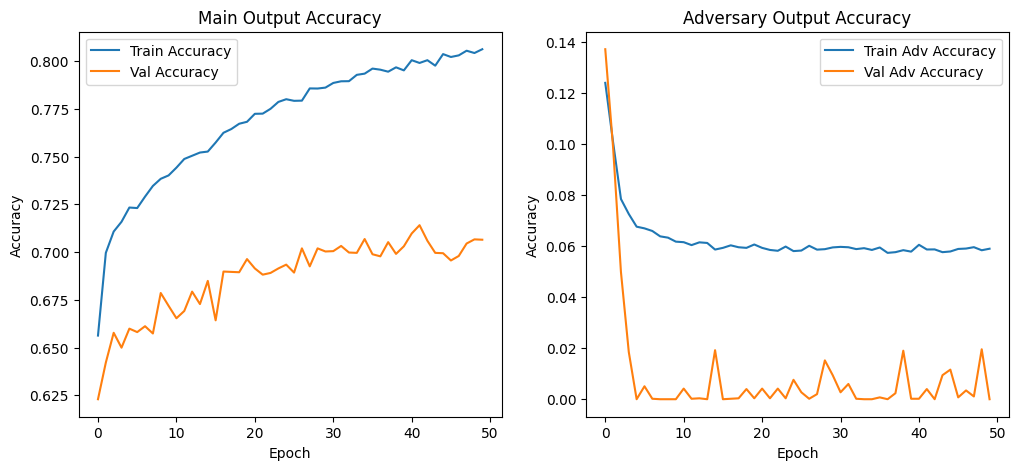

In [59]:
import matplotlib.pyplot as plt

# Plot main output accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['main_output_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_main_output_accuracy'], label='Val Accuracy')
plt.title('Main Output Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot adversary output accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['adv_output_accuracy'], label='Train Adv Accuracy')
plt.plot(history.history['val_adv_output_accuracy'], label='Val Adv Accuracy')
plt.title('Adversary Output Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [60]:
# Evaluate the model
results = model_adv.evaluate(
    X_test,
    y_val_dict,
    verbose=0
)

print(f"\nTest Loss (Main Output): {results[1]:.4f}")
print(f"Test Accuracy (Main Output): {results[3]*100:.2f}%")
print(f"Test Loss (Adversary Output): {results[2]:.4f}")
print(f"Test Accuracy (Adversary Output): {results[4]*100:.2f}%")



Test Loss (Main Output): 1.1066
Test Accuracy (Main Output): 70.64%
Test Loss (Adversary Output): 0.3580
Test Accuracy (Adversary Output): 0.00%


In [ ]:
# Predict on the test set
y_pred_proba, _ = model_adv.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()


print("\nClassification Report:")
print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)


roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")


173/173 [==============================] - 0s 447us/step

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.75      0.79      4156
           1       0.43      0.57      0.49      1366

    accuracy                           0.71      5522
   macro avg       0.64      0.66      0.64      5522
weighted avg       0.74      0.71      0.72      5522


Confusion Matrix:
[[3125 1031]
 [ 590  776]]

ROC-AUC Score: 0.7240


In [ ]:

accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy * 100:.2f}%")



Model Accuracy: 70.64%


In [77]:
# Combine predictions and sensitive attributes
results_df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred
})

# Add sensitive attributes
sensitive_test_df = pd.DataFrame(sensitive_test, columns=sensitive_encoded.columns)
results_df = pd.concat([results_df.reset_index(drop=True), sensitive_test_df.reset_index(drop=True)], axis=1)

def demographic_parity_difference(df, sensitive_prefix, min_group_size=50):
    sensitive_cols = [col for col in df.columns if col.startswith(sensitive_prefix)]
    dpd_values = {}
    for col in sensitive_cols:
        group = df[df[col] == 1]
        if len(group) >= min_group_size:
            rate = group['y_pred'].mean()
            dpd_values[col] = rate
        else:
            dpd_values[col] = np.nan  # Exclude small groups
    dpd_values = {k: v for k, v in dpd_values.items() if not np.isnan(v)}
    max_rate = max(dpd_values.values())
    min_rate = min(dpd_values.values())
    dpd = max_rate - min_rate
    return dpd, dpd_values


# Calculate for 'race'
dpd_race, dpd_race_values = demographic_parity_difference(results_df, 'race_')
print(f"\nDemographic Parity Difference for Adv (Race): {dpd_race:.4f}")
print("Rates by Race:")
for race, rate in dpd_race_values.items():
    print(f"  {race}: {rate:.4f}")

# Calculate for 'sex'
dpd_sex, dpd_sex_values = demographic_parity_difference(results_df, 'sex_')
print(f"\nDemographic Parity Difference Adv (Sex): {dpd_sex:.4f}")
print("Rates by Sex:")
for sex, rate in dpd_sex_values.items():
    print(f"  {sex}: {rate:.4f}")



Demographic Parity Difference for Adv (Race): 0.4866
Rates by Race:
  race_Asian/Pacific Islander: 0.0631
  race_Black: 0.5496
  race_Hispanic: 0.0932
  race_White: 0.1979

Demographic Parity Difference Adv (Sex): 0.0911
Rates by Sex:
  sex_Female: 0.2612
  sex_Male: 0.3523


Demographic Parity Difference (DPD) measures the difference in the positive prediction rates (the proportion of individuals predicted as recidivists) across demographic groups. Ideally, DPD should be close to zero, indicating that positive prediction rates are similar across groups. A large DPD value suggests that some groups are more likely to receive positive predictions than others, indicating potential bias. 

In [69]:
white_hispanic_count = df[df['race'] == 'White (Hispanic)'].shape[0]
print(white_hispanic_count)


23


A score of 1.0000 is abnormally high. We observe that race_white (Hispanic) individuals have a DPD score of 1.0000 which warrants further investigation. Upon further analysis, we find that there are only 23 individuals in the dataset with over 60,000 observations that classify as white (Hispanic), which warrants further conversations about if we can draw conclusions from this information. 

Excluding race_white (Hispanic) until further analysis can be computed, we see that those who identify as black have the highest DPD score at 0.5496. This score is over double than the second highest DPD Score, which is associated with Native Americans.

After removing "White (Hispanic)," the **adversarial model** shows a lower **Demographic Parity Difference (DPD) for race** at **0.4866** compared to the **main model's** DPD of **0.5751**, indicating improved fairness across racial groups in the adversarial model. For sex, both models remain similar, with the adversarial model at **0.0911** and the main model at **0.0953**, showing consistent gender equity in both approaches.

Further considerations:

Refactor Code into Modular Functions: improves readability and allows for easier debugging and testing.
Enhance Documentation: Adding docstrings and detailed comments will make your codebase more accessible to others.
Implement Additional Fairness Metrics.
Conduct In-Depth Exploratory Data Analysis: Before modeling, thoroughly explore the data to uncover patterns, correlations, and potential issues.
Apply Cross-Validation and Hyperparameter Tuning: This can lead to better-performing models that generalize well to unseen data.
Consider Ethical Implications in Depth: Given the sensitive nature of recidivism prediction, incorporating a discussion on the ethical considerations would strengthen analysis.